# Iterative Local Search heuristic - ILS

This notebook provides a hands-on approach to implementing the Iterated Local Search (ILS) heuristic. The focus is on implementing this heuristic and testing it on two types of datasets: a real dataset (Karate) and synthetic datasets. Two synthetic datasets will be selected, each with a different value of mu (0.15 and 0.4).

### Table of content
   
- [Elementary Functions](#Elementary-Functions)
- [Test 1: Real dataset Karate](#Test-1-Real-dataset-Karate)
- [Test 2: Synthetic dataset mu = 0.15](#Test-2-Synthetic-dataset-mu-015)
- [Test 3: Synthetic dataset mu = 0.4](#Test-3-Synthetic-dataset-mu-04)




# Elementary Functions

In [ ]:
import numpy as np
import matplotlib as plt
import itertools
import time
import math

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def matrice_adjacente_vers_graphe(matrice_adjacente):
    # Création d'un graphe non dirigé
    G = nx.Graph()

    # Ajout des arêtes au graphe en fonction de la matrice d'adjacence
    for i in range(len(matrice_adjacente)):
        for j in range(len(matrice_adjacente[i])):
            if matrice_adjacente[i][j] == 1:
                G.add_edge(i, j)

    return G


In [ ]:
def dat_to_adjacency_matrix(file_path):
    # Read data from the .dat file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize an empty dictionary to store edges
    edges = {}

    # Process each line in the file
    for line in lines:
        # Split the line into two nodes
        node1, node2 = map(int, line.strip().split())

        # Add the nodes to the dictionary
        if node1 in edges:
            edges[node1].append(node2)
        else:
            edges[node1] = [node2]

    # Determine the number of nodes in the network
    num_nodes = max(edges.keys())

    # Initialize an empty adjacency matrix
    adj_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    # Fill the adjacency matrix based on the edges
    for node1 in edges:
        for node2 in edges[node1]:
            adj_matrix[node1 - 1][node2 - 1] = 1  # Subtract 1 to adjust for 0-based indexing

    return np.array(adj_matrix)


In [ ]:
def calculate_Q(graph,solution):
     Q = 0
     m = graph.number_of_edges()
     for community in solution:
            Auv = sum(1 for u in community for v in community if graph.has_edge(u, v))
            du = sum(1 for u in community for v in graph.neighbors(u))
            dv = sum(1 for v in community for u in graph.neighbors(v))
            Q += (Auv - (du * dv) / (2 * m))
     return(Q / (2 * m))

#### Initialization: Setting up the initial solution.

In [ ]:
import networkx as nx
import random

# Function to perform the greedy constructive heuristic for community detection
def greedy_constructive_heuristic(graph):
    # Initialize an empty dictionary to store communities
    community_dict = {}

    # Get the set of all nodes in the graph
    V = set(graph.nodes())

    # Iterate until all nodes are assigned to communities
    while V:
        # Select a random vertex from the set of remaining vertices
        v = random.choice(list(V))

        # Dictionary to store modularity change for each community
        Qnew_dict = {}

        # If no communities exist yet, initialize the first community with the vertex
        if not community_dict:
            community_dict[0] = {v}
            V.remove(v)
            continue

        # Try adding the vertex to each community and compute modularity change
        for comm_id, nodes in community_dict.items():
            new_nodes = nodes | {v}
            # Calculate the change in modularity when adding the vertex to the community
            Qnew = calculate_Q(graph, list(community_dict.values()) + [new_nodes]) - calculate_Q(graph, list(community_dict.values()))
            Qnew_dict[comm_id] = Qnew

        # Find the community with maximum increase in modularity
        max_comm_id = max(Qnew_dict, key=Qnew_dict.get)
        max_increase = Qnew_dict[max_comm_id]

        # Add the vertex to the corresponding community
        if max_increase > 0:
            community_dict[max_comm_id].add(v)
        else:
            # If modularity doesn't increase, create a new community with the vertex
            max_comm_id = max(community_dict.keys()) + 1
            community_dict[max_comm_id] = {v}

        # Remove the selected vertex from the set of remaining vertices
        V.remove(v)

    # Return the list of communities
    return list(community_dict.values())


#test
# Generate an initial solution using the Greedy Constructive Heuristic (GCH)
#initial_solution = greedy_constructive_heuristic(graph)
#print("Initial solution:", initial_solution)


#### Local Search: A phase in the algorithm where the current solution is iteratively improved by exploring its neighborhood.

In [ ]:
def merging(Ci,Cj,solution):
     new=solution[:]
     nodes_in_c1 = solution[Ci]
     nodes_in_c2 = solution[Cj]
     merged_nodes = nodes_in_c1.union(nodes_in_c2)
     new[Ci] = merged_nodes
     del new[Cj]
     return(new)

In [ ]:
def calculate_delta_Q(graph, Ci, Cj,solution):

     old=calculate_Q(graph,solution)
     new=merging(Ci,Cj,solution)
     newQ=calculate_Q(graph,new)
     delta=newQ-old
     return delta

In [ ]:
from itertools import combinations

def merge_loop(graph, solution, Flag):
    continu = True
    stored = 0
    merge = False
    Flag = True

    community_pairs = list(combinations(range(len(solution)), 2))

    for i in range(len(community_pairs)):
        if i < len(community_pairs):
            delta_Q = calculate_delta_Q(graph, community_pairs[i][0], community_pairs[i][1], solution)

            if delta_Q > 0:
                merge = True
                solu_without_selected_comm = solution[:]
                del solu_without_selected_comm[community_pairs[i][0]]
                del solu_without_selected_comm[community_pairs[i][1] - 1]  # Adjust the index here

                for community in solu_without_selected_comm:
                    index = solution.index(community)
                    if (calculate_delta_Q(graph, community_pairs[i][0], index, solution) > delta_Q or
                        calculate_delta_Q(graph, community_pairs[i][1], index, solution) > delta_Q):
                        merge = False

                if merge:
                    solution = merging(community_pairs[i][0], community_pairs[i][1], solution)
                    Flag = False
                    community_pairs = list(combinations(range(len(solution)), 2))

    return solution, Flag


In [ ]:
import random

def remove_empty_sets(solution):
    return [community for community in solution if community]

def select_random(L):
    return random.randint(0, len(L) - 1)


def get_communities_nodes(nodes, solution):
    node_communities = []
    for node in nodes:
        for i, community in enumerate(solution):
            if node in community:
                 if i not in node_communities :
                  node_communities.append(i)
                 break  # Sortir de la boucle dès que la communauté est trouvée
    return node_communities




def modularity_label(graph, community, v):
    Q = 0
    m = graph.number_of_edges()

    # Calculate the fraction of edges within the community
    Auv = sum(1 for u in community if graph.has_edge(u, v))
    # Calculate the degree of nodes in the community
    du = sum(1 for u in community for v in graph.neighbors(u))
    dv = sum(1 for v in graph.neighbors(v))
    # Update modularity
    Q += (Auv - (du * dv) / (2 * m))

    return Q



# Fonction pour mettre à jour les étiquettes des nœuds dans une communauté
def label_update(v, graph, solution , cl):
    max_value = -float('inf')
    best_label = cl
    nodes = list(graph.neighbors(v))
    labels_neighbors = get_communities_nodes(nodes, solution)
    for lu in labels_neighbors:
        # recuperer les nodes de la community lu
        community = solution[lu]
        value = modularity_label(graph , community , v)
        if value > max_value:
            max_value = value
            best_label = lu

    # m_a_j des clusters
    solution[cl].remove(v)
    solution[best_label].add(v)
    solution = remove_empty_sets(solution)
    return solution

def update_L(L, solution, Cl):
    # Créer une copie de la liste solution
    updated_solution = solution[:]
    # Supprimer l'élément à l'indice Cl de la copie
    del updated_solution[Cl]
    # Mettre à jour la liste L
    L = updated_solution




# Implémentation de la procédure LS
def LS(graph, solution):
    flag = False
    C = 0
    while not flag:
        L = solution[:]
        while L:
            Cl = select_random(L)
            del L[Cl]
            to_remove = list(solution[Cl])

            for v in to_remove:
                label_update(v, graph, solution,Cl)
                update_L(L,solution,Cl)

        flag = True
        solution,flag = merge_loop(graph, solution, flag)
        solution = remove_empty_sets(solution)



    return solution
#test
#optimized_solution = LS(graph, initial_solution)
#print("Optimized Solution:", optimized_solution)


#### Perturbation: A mechanism to escape local optima by introducing randomness or shaking the current solution.

In [ ]:
def is_boundary_node(graph, node, communities):

    #get the neighbors of the node
    neighbors = set(graph.neighbors(node))
    node_community = None
    #identify the community to which the node belongs
    for i, community in enumerate(communities):
        if node in community:
            node_community = i
            break
    is_boundary = False
    #if we find one neighbor that is not in the node's community then it is a boundary node
    for nod in neighbors :
        if any(nod in comm for j, comm in enumerate(communities) if j != node_community):
            is_boundary = True
            break
    #we return false if we find no neighbor in a different community
    return is_boundary



def Move(graph, solution, beta):
    #first perturbation function where we move boundary nodes into neighboring communities
    eligible_communities = []
    for community in solution :
        if (len(community)>1):
            eligible_communities.append(community)
    #identify all the neighboring nodes in the graph
    boundary_nodes = []
    for node in graph.nodes():
        if is_boundary_node(graph , node , eligible_communities):
            boundary_nodes.append(node)
    #compute the number of nodes to move
    num_nodes_to_move = int(beta * len(boundary_nodes))
    #select randomly the nodes to move
    nodes_to_move = random.sample(boundary_nodes, num_nodes_to_move)
    #for each node we have to move
    for node in nodes_to_move:
        #find the community to which the node belongs
        for i, community in enumerate(solution):
            if node in community :
                current_community_index = i
                break
         #find its nieghboring communities
        neighbor_communities = []
        for i, community in enumerate(solution):
            if i != current_community_index:
                for neighbor in graph.neighbors(node):
                    if neighbor in community :
                        if community not in list(neighbor_communities):
                            neighbor_communities.append(community)
        #select a new community for the node
        new_community = random.choice(list(neighbor_communities))

        #remove the node from its current community
        if current_community_index is not None:
            solution[current_community_index].remove(node)
            #if the the node was a singleton delete the empty community
            if solution[current_community_index] == set():
                del solution[current_community_index]
        #find the index of the new community
        for i, community in enumerate(solution):
            if new_community == community:
                new_community_index = i
                break
        #add the node the new community
        solution[new_community_index].add(node)
    return solution


def Singleton(graph, solution, gamma):
    current_communities = list(solution)
    if len(solution)<gamma:
        gamma = len(solution)
    selected_communities = random.sample(current_communities, gamma)
    new_solution = []
    for community in selected_communities:
        for node in community:
            new_solution.append({node})

        # Find the index of the current community in the original solution
        community_index = solution.index(community)

        # Remove the current community from the original solution
        del solution[community_index]

    # Append the new communities to the original solution
    solution.extend(new_solution)
    return solution




def perturbation(graph, solution):

    k = random.randint(1, 2)
    if k == 1:
        new = Move(graph, solution, beta=0.1)
    elif k == 2:
        new = Singleton(graph, solution, gamma=2)

    return new

#test
#print("the solution going into the algorithm is :")
#print(optimized_solution)
#perturbed_solution = perturbation(graph , (optimized_solution))
#print("Perturbed solution:", perturbed_solution)

#### Acceptance Criterion: A rule to decide whether a new solution should replace the current one.

In [ ]:
import math
import random

def acceptance_criterion(graph, incumbent_solution, current_solution, t):
  #we calculate the modularity for both the incumbent solution and the current one
    modularity_incumbent = calculate_Q(graph,incumbent_solution)
    modularity_current = calculate_Q(graph,current_solution)
    #if the current modularity is better we select it
    if modularity_current >= modularity_incumbent:
        incumbent_solution = current_solution
    else:
      #if not we calculate a random probability of selecting it
        probability = math.exp((modularity_current - modularity_incumbent) / t)
        if random.random() <= probability:
            incumbent_solution = current_solution
    t = t* 0.9

    return incumbent_solution, t


#test
#acceptance_solution ,T = acceptance_criterion(graph , optimized_solution,optimized_solution_2 ,  1)
#print("Accepted Solution:", acceptance_solution)


## Iterated Local Search (ILS): An iterative metaheuristic that combines local search with perturbation to find better solutions.

In [ ]:
import random
import numpy as np


# Main ILS algorithm
def ils_algorithm(graph):
    solution_0 = greedy_constructive_heuristic(graph)
    incumbent_solution = LS(graph, solution_0)
    best_solution = incumbent_solution
    it_nb = 0  # Initialize runtime
    t = 0.025 * calculate_Q(graph,best_solution)
    modularity = 0
    while (it_nb < 30 )  :
        perturbed_solution = perturbation(graph, incumbent_solution)

        local_optimal_solution = LS(graph, perturbed_solution)
        incumbent_solution , t = acceptance_criterion(graph,incumbent_solution,local_optimal_solution,t)
        # Update best solution if necessary
        if calculate_Q(graph,incumbent_solution) > calculate_Q(graph,best_solution):
            best_solution = incumbent_solution

        it_nb += 1  # Increment runtime



    return best_solution

# Example usage
# Call the main ILS algorithm with your graph
#best_community_structure = ils_algorithm(graph)


# Test 1: Real dataset Karate with details for each function

In [ ]:
import networkx as nx
import plotly.graph_objects as go

# Read the GML file and create a NetworkX graph object
graph = nx.read_gml('DataSets/réels/karate/karate.gml',label="id")

# Now you can work with the graph object, for example, you can get basic information about the graph:
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

Number of nodes: 34
Number of edges: 78


In [ ]:
# Generate an initial solution using the Greedy Constructive Heuristic (GCH)
initial_solution = greedy_constructive_heuristic(graph)
print("Initial solution:", initial_solution)

Initial solution: [{1}, {2, 3, 5, 7, 8, 10, 18, 24, 25, 26, 28, 29}, {4, 6, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 27, 30, 31, 32, 33, 34}, {9}, {11}]


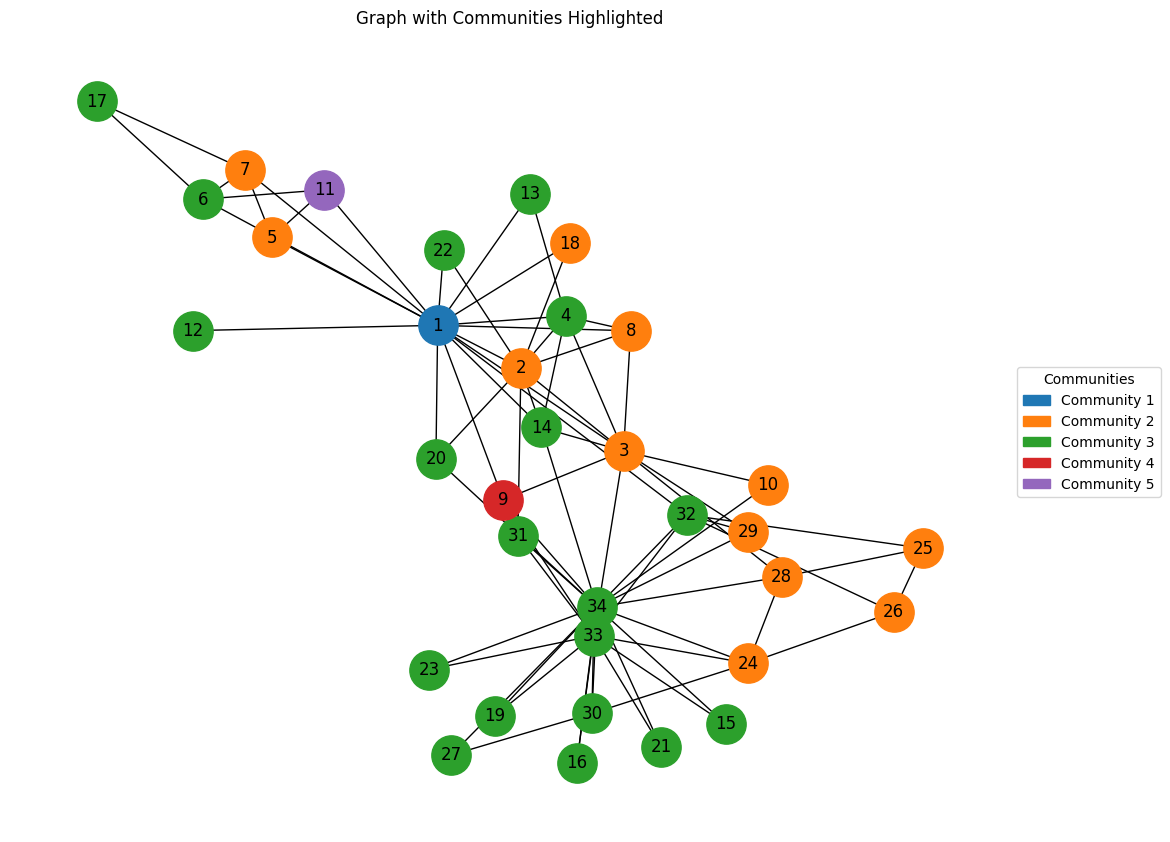

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graph, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(initial_solution):
    nodes_in_community = [node for node in community if node in graph.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


In [ ]:
optimized_solution = LS(graph, initial_solution)
print("Optimized Solution:", optimized_solution)

Optimized Solution: [{32, 25, 26, 28, 29, 24}, {33, 34, 9, 10, 15, 16, 19, 21, 23, 27, 30, 31}, {1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22}]


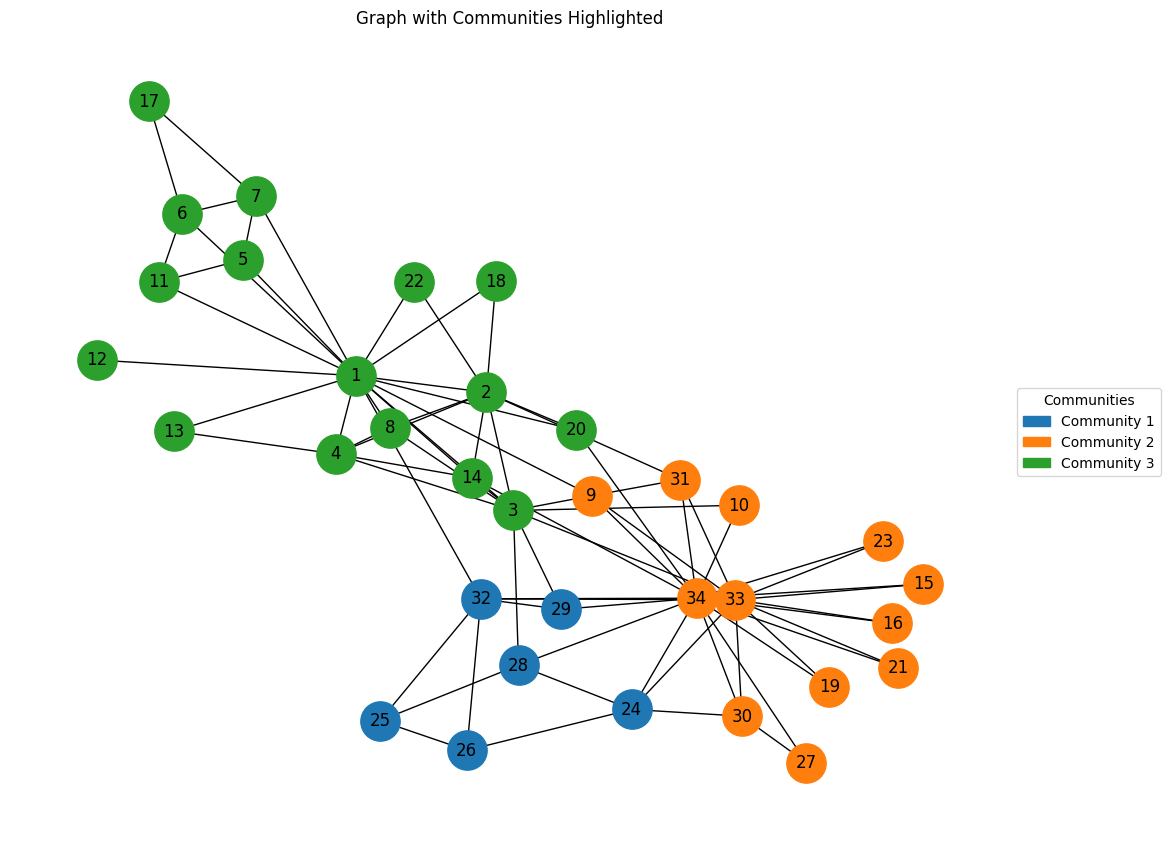

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graph, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(optimized_solution):
    nodes_in_community = [node for node in community if node in graph.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


In [ ]:
print("the solution going into the algorithm is :", optimized_solution)
perturbed_solution = perturbation(graph , (optimized_solution))
print("Perturbed solution:", perturbed_solution)

the solution going into the algorithm is : [{32, 25, 26, 28, 29, 24}, {33, 34, 9, 10, 15, 16, 19, 21, 23, 27, 30, 31}, {1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22}]
Perturbed solution: [{1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22}, {32}, {25}, {26}, {28}, {29}, {24}, {33}, {34}, {9}, {10}, {15}, {16}, {19}, {21}, {23}, {27}, {30}, {31}]


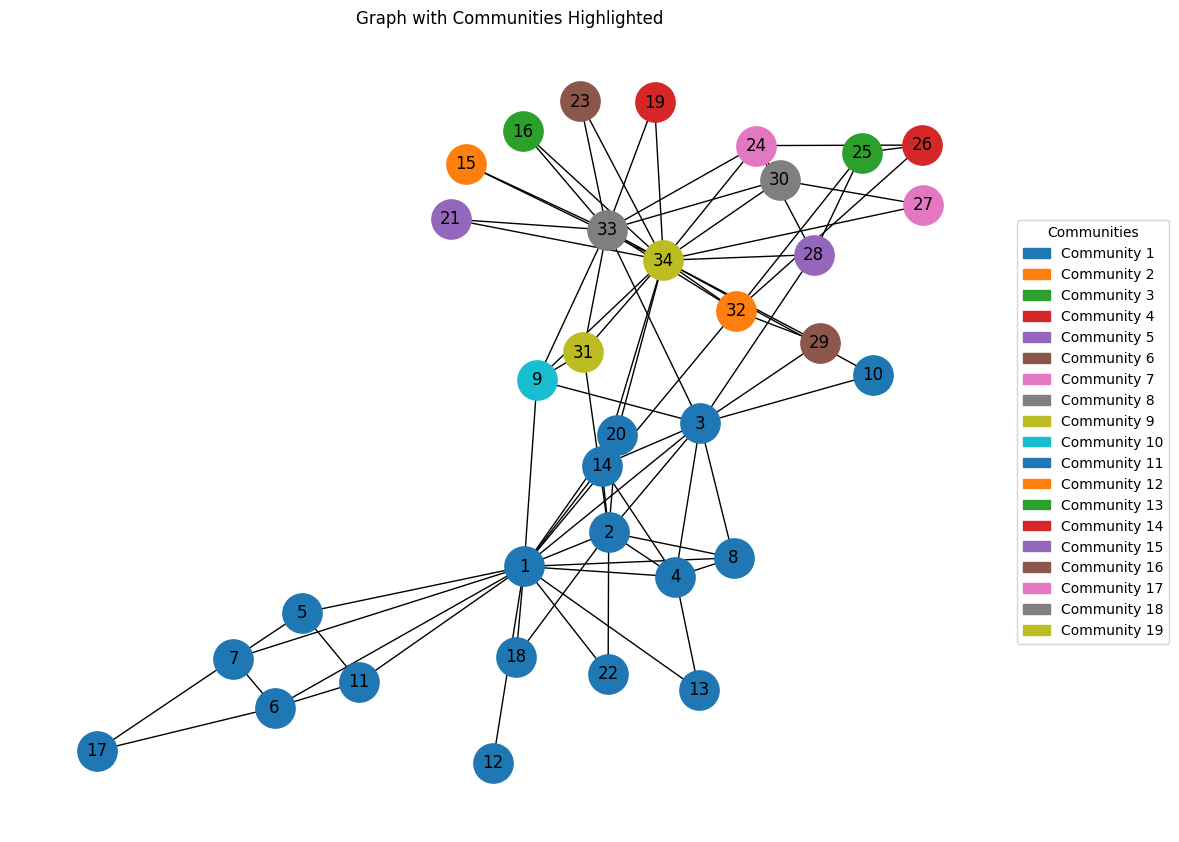

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graph, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(perturbed_solution):
    nodes_in_community = [node for node in community if node in graph.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


Optimized Solution 2: [{1, 2, 4, 7, 5, 6, 11, 13, 14, 8, 12, 17, 18, 20, 22}, {32, 3, 26, 10, 28, 29, 25}, {33, 34, 9, 15, 16, 19, 21, 23, 24, 27, 30, 31}]


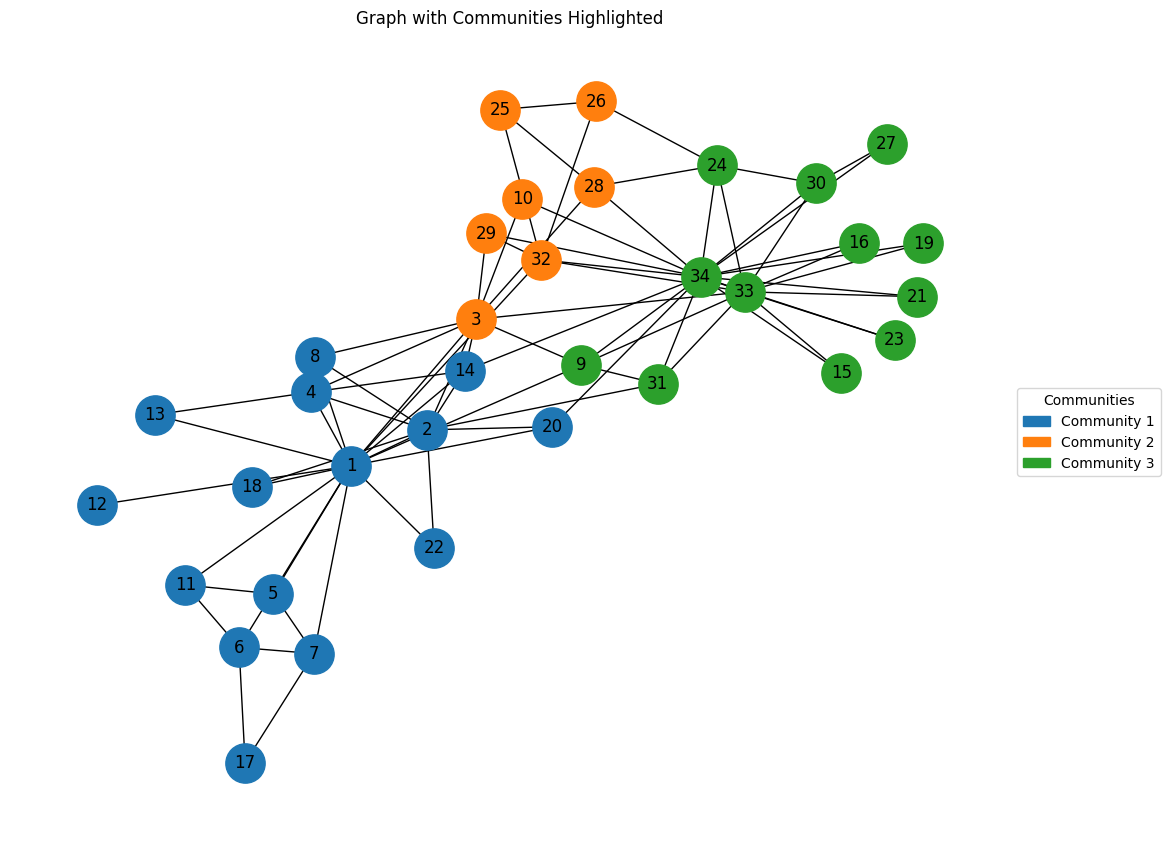

In [ ]:
optimized_solution_2 = LS(graph, perturbed_solution)
print("Optimized Solution 2:", optimized_solution_2)

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graph, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(optimized_solution_2):
    nodes_in_community = [node for node in community if node in graph.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


Accepted Solution: [{1, 2, 4, 7, 5, 6, 11, 13, 14, 8, 12, 17, 18, 20, 22}, {32, 3, 26, 10, 28, 29, 25}, {33, 34, 9, 15, 16, 19, 21, 23, 24, 27, 30, 31}]


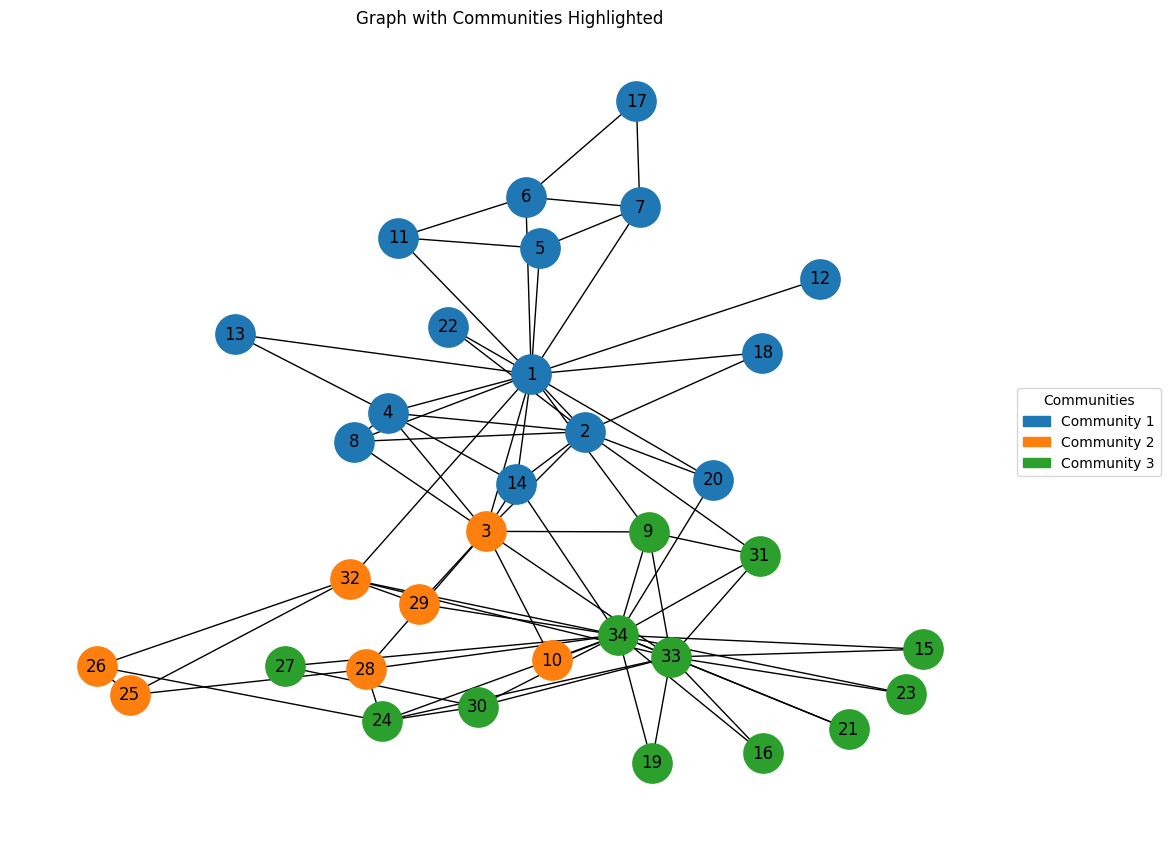

In [ ]:
acceptance_solution ,T = acceptance_criterion(graph , optimized_solution,optimized_solution_2 ,  1)
print("Accepted Solution:", acceptance_solution)
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graph, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(acceptance_solution):
    nodes_in_community = [node for node in community if node in graph.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


# ILS algorithme in karate dataset

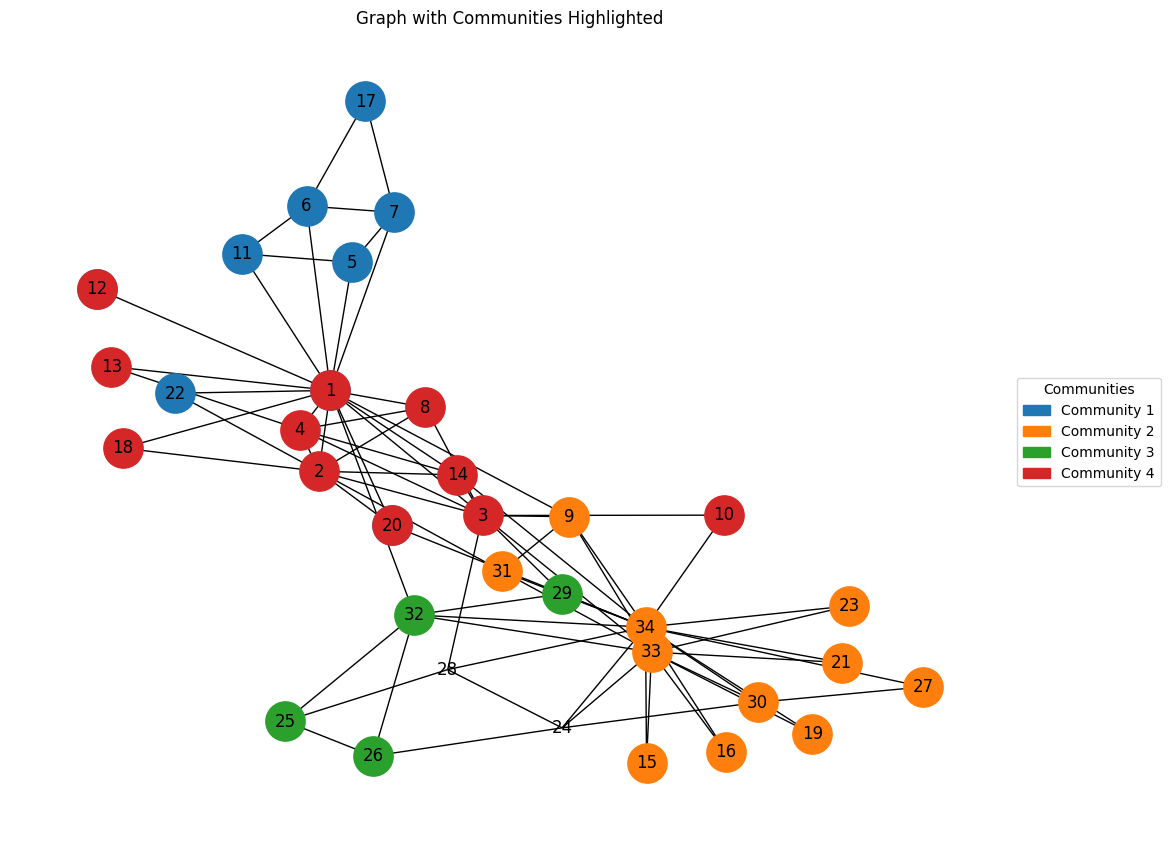

In [ ]:
import time
start_time = time.time()
best_community_structure = ils_algorithm(graph)
elapsed_time = time.time() - start_time
modularity = calculate_Q(graph,best_community_structure)

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graph, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(best_community_structure):
    nodes_in_community = [node for node in community if node in graph.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()


In [ ]:
modularity = calculate_Q(graph,best_community_structure)

## and this one from data in .txt format like karate dataset
from sklearn.metrics import normalized_mutual_info_score
best_community_structure
# Open the text file for reading
with open(r"DataSets/réels/karate/groundTruth.txt", "r") as file:
    # Read the contents of the file
    file_contents = file.read()
# Split the contents by newline character to create an array
array_data = file_contents.split("\n")
# Convert array elements to integers
array_data = [int(value) for value in array_data if value.strip()]  # Convert non-empty values to integers
# Print the resulting array
print(array_data)

# Filter out empty sets from the best_community_structure list
non_empty_sets = [community_set for community_set in best_community_structure if community_set]

# Find the maximum element from the non-empty sets
max_element = max(max(community_set) for community_set in non_empty_sets)

# Initialize the simple array with length equal to the maximum element
simple_array = [0] * max_element

# Initialize the simple array with length equal to the maximum element
simple_array = [0] * max_element
# Iterate over each set and assign the index to each element in the set
for i, community_set in enumerate(best_community_structure):
    for elem in community_set:
        simple_array[elem - 1] = i

#convert the structure to be sorted by class label
value_to_index = {}
index = 0
for value in simple_array:
    if value not in value_to_index:
        value_to_index[value] = index
        index += 1

# Replace values in the list with their corresponding indices
simple_array = [value_to_index[value] for value in simple_array]

print(simple_array)
nmi = normalized_mutual_info_score(array_data, simple_array)

print("La modularité du graphe obtenu est :",modularity)
print("elapsed time of ILS algorithm:", elapsed_time,"secondes")
print(f"Normalized Mutual Information: {nmi}")

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 1, 2, 1, 3, 3, 2, 1, 3, 2, 2, 3, 2, 2]
La modularité du graphe obtenu est : 0.4200772518080211
elapsed time of ILS algorithm: 5.356513023376465 secondes
Normalized Mutual Information: 0.4573818813874756


# Test 2: Synthetic dataset mu = 0.15

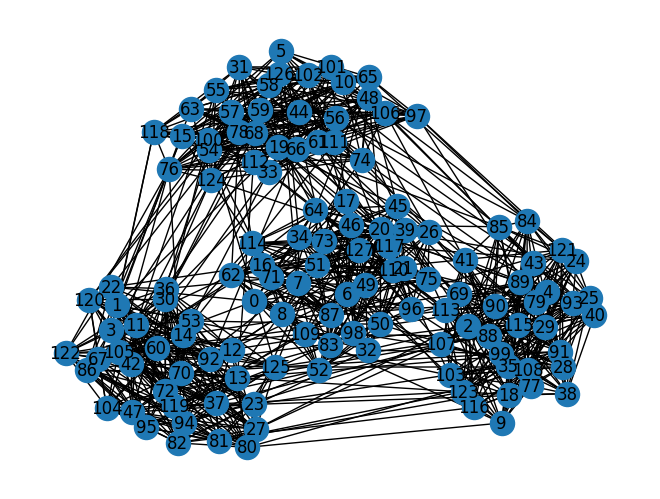

La modularité resultant est  0.6015625
elapsed time of ILS algorithm: 289.4175639152527 secondes
Normalized Mutual Information: 1.0


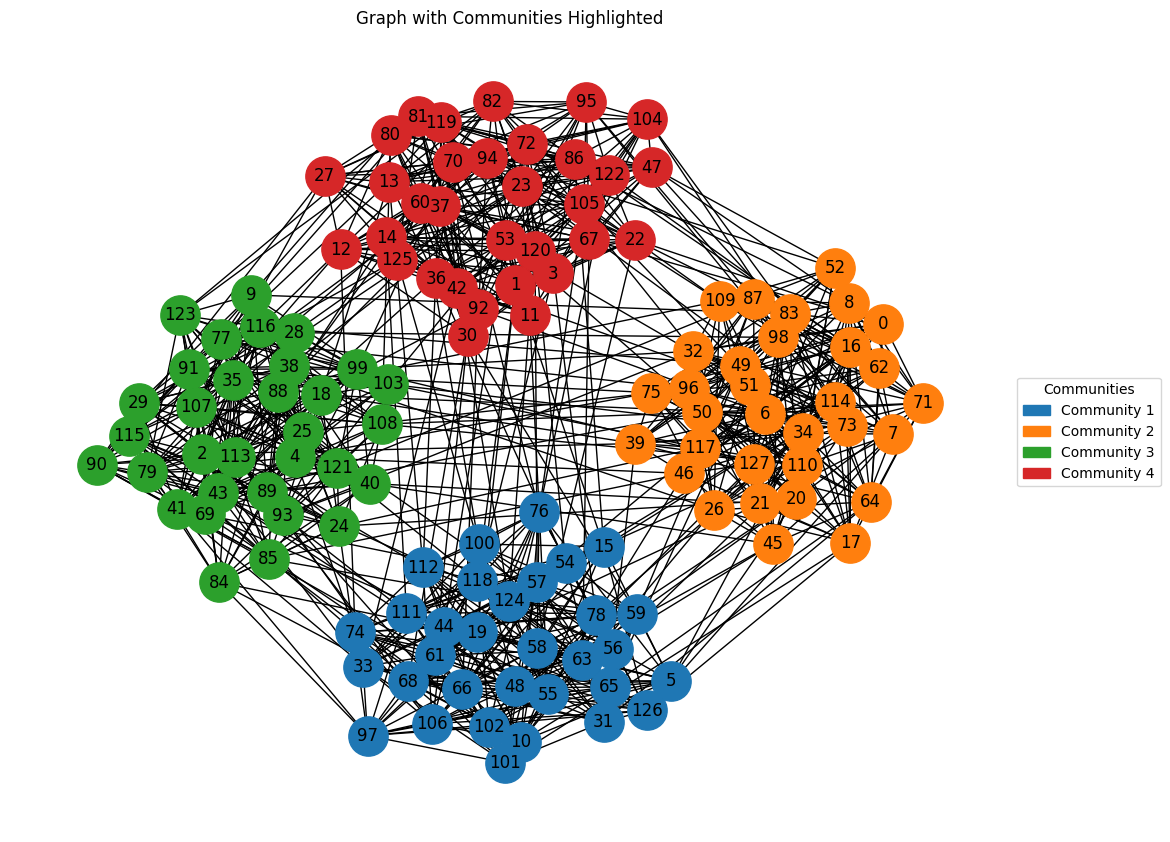

In [ ]:


file_path = "0.15/network.dat"
matrix = dat_to_adjacency_matrix(file_path)
graph = matrice_adjacente_vers_graphe(matrix)
nx.draw(graph, with_labels=True)
plt.show()


# Call the main ILS algorithm with your graph
start_time = time.time()
best_community_structure = ils_algorithm(graph)
elapsed_time = time.time() - start_time
modularity = calculate_Q(graph,best_community_structure)


from sklearn.metrics import normalized_mutual_info_score
# Given community structure dictionary
community_structure = best_community_structure
# Read the true community labels from the community.dat file
true_community_labels = {}
with open("0.15/community.dat", 'r') as file:
    for line in file:
        # Assuming each line contains node ID followed by its community label
        node_id, community_label = map(int, line.strip().split())
        true_community_labels[node_id] = community_label
predicted_community_labels = {}
# Iterate over each set in the list 'ours'
for label, community_set in enumerate(best_community_structure):
    for node_id in community_set:
        predicted_community_labels[node_id] = label + 1
sorted_predicted_labels = dict(sorted(predicted_community_labels.items()))
adjusted_predicted_labels = {key + 1: value for key, value in sorted_predicted_labels.items()}
adjusted_predicted_labels_list = [adjusted_predicted_labels[i] for i in range(1, len(adjusted_predicted_labels) + 1)]
true_community_labels_list = list(true_community_labels.values())
adjusted_predicted_labels_list = list(adjusted_predicted_labels_list)
mapping = {1: 4, 2: 3, 3: 1, 4: 2}
true_community_labels_list = [mapping[val] for val in true_community_labels_list]
value_to_index = {}
index = 1  # Start indexing from 1
for value in adjusted_predicted_labels_list:
    if value not in value_to_index:
        value_to_index[value] = index
        index += 1

# Replace values in the list with their corresponding indices
adjusted_predicted_labels_list = [value_to_index[value] for value in adjusted_predicted_labels_list]
nmi = normalized_mutual_info_score(true_community_labels_list, adjusted_predicted_labels_list)



print("La modularité resultant est " , modularity)
print("elapsed time of ILS algorithm:", elapsed_time,"secondes")
print(f"Normalized Mutual Information: {nmi}")


# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graph, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(best_community_structure):
    nodes_in_community = [node for node in community if node in graph.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()

# Test 3: Synthetic dataset mu = 0.4

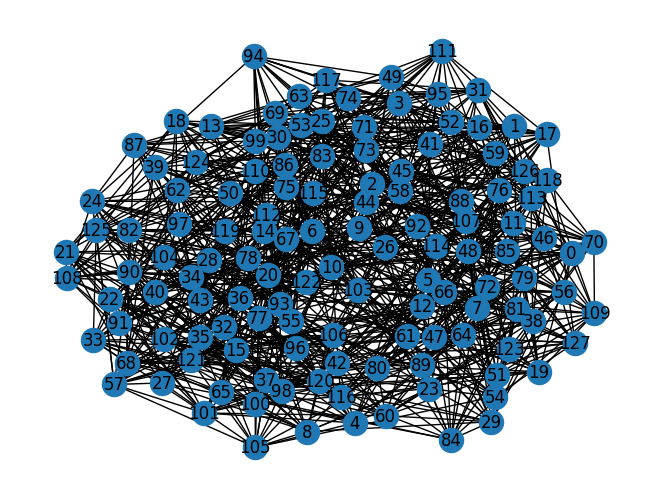

La modularité resultant est  0.34765625
elapsed time of ILS algorithm: 273.5659909248352 secondes
predicted [1, 2, 2, 2, 3, 1, 4, 1, 3, 2, 4, 1, 3, 2, 4, 3, 2, 2, 4, 1, 3, 3, 3, 1, 4, 2, 2, 4, 4, 1, 4, 2, 3, 3, 3, 3, 3, 3, 1, 4, 3, 2, 3, 4, 2, 2, 1, 1, 1, 2, 4, 1, 2, 2, 1, 4, 1, 3, 2, 2, 1, 1, 4, 2, 1, 3, 1, 3, 3, 2, 1, 4, 1, 2, 2, 4, 1, 4, 4, 1, 1, 1, 4, 4, 1, 1, 4, 4, 2, 1, 3, 4, 2, 3, 2, 2, 3, 4, 3, 2, 3, 3, 3, 4, 3, 3, 3, 2, 4, 1, 4, 2, 4, 2, 1, 4, 3, 2, 1, 4, 3, 3, 4, 1, 4, 4, 2, 1]
true [1, 2, 2, 2, 3, 1, 4, 1, 3, 2, 4, 1, 3, 2, 4, 3, 2, 2, 4, 1, 3, 3, 3, 1, 4, 2, 2, 4, 4, 1, 4, 2, 3, 3, 3, 3, 3, 3, 1, 4, 3, 2, 3, 4, 2, 2, 1, 1, 1, 2, 4, 1, 2, 2, 1, 4, 1, 3, 2, 2, 1, 1, 4, 2, 1, 3, 1, 3, 3, 2, 1, 4, 1, 2, 2, 4, 1, 4, 4, 1, 1, 1, 4, 4, 1, 1, 4, 4, 2, 1, 3, 4, 2, 3, 2, 2, 3, 4, 3, 2, 3, 3, 3, 4, 3, 3, 3, 2, 4, 1, 4, 2, 4, 2, 1, 4, 3, 2, 1, 4, 3, 3, 4, 1, 4, 4, 2, 1]
Normalized Mutual Information: 1.0


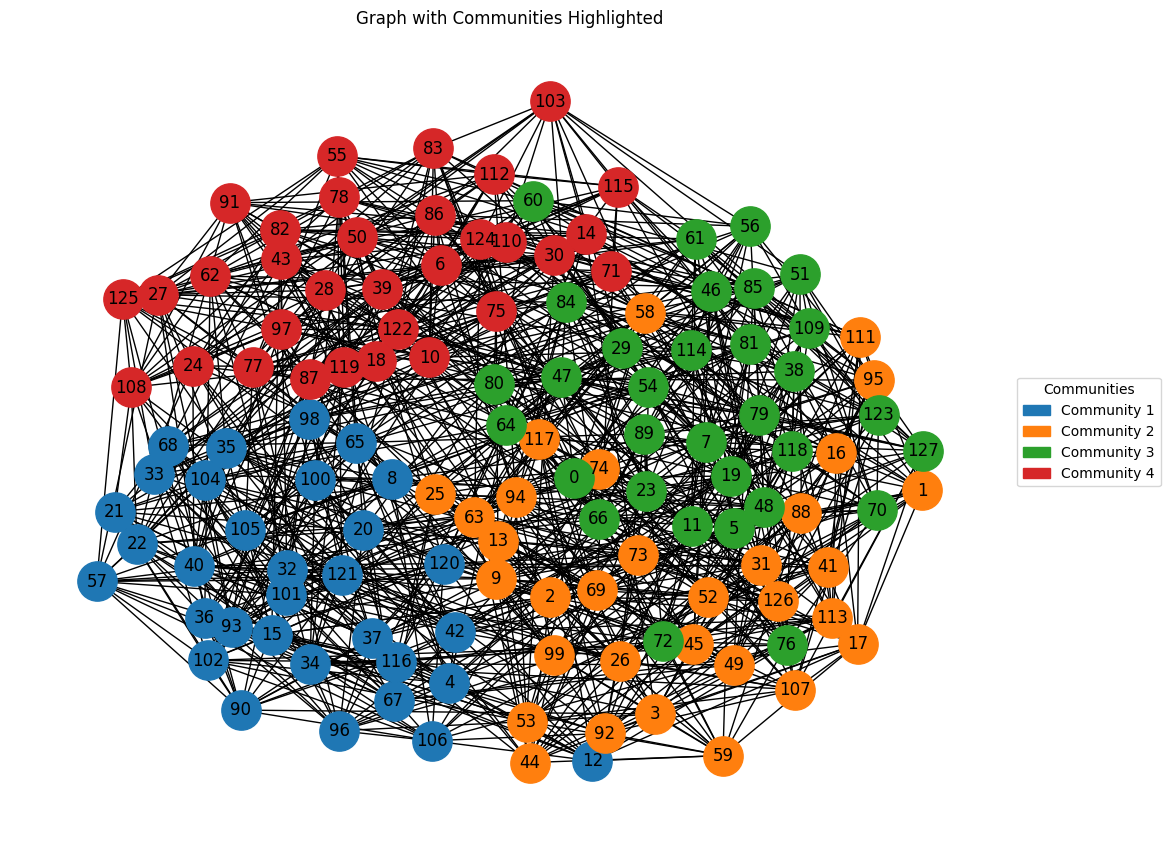

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
def matrice_adjacente_vers_graphe(matrice_adjacente):
    # Création d'un graphe non dirigé
    G = nx.Graph()

    # Ajout des arêtes au graphe en fonction de la matrice d'adjacence
    for i in range(len(matrice_adjacente)):
        for j in range(len(matrice_adjacente[i])):
            if matrice_adjacente[i][j] == 1:
                G.add_edge(i, j)

    return G

file_path = "0.40/network.dat"
matrix = dat_to_adjacency_matrix(file_path)
graphe = matrice_adjacente_vers_graphe(matrix)
nx.draw(graphe, with_labels=True)
plt.show()


start_time = time.time()
best_community_structure = ils_algorithm(graphe)
elapsed_time = time.time() - start_time
modularity = calculate_Q(graphe,best_community_structure)


from sklearn.metrics import normalized_mutual_info_score
# Given community structure dictionary
community_structure = best_community_structure
# Read the true community labels from the community.dat file
true_community_labels = {}
with open("0.40/community.dat", 'r') as file:
    for line in file:
        # Assuming each line contains node ID followed by its community label
        node_id, community_label = map(int, line.strip().split())
        true_community_labels[node_id] = community_label
predicted_community_labels = {}
# Iterate over each set in the list 'ours'
for label, community_set in enumerate(best_community_structure):
    for node_id in community_set:
        predicted_community_labels[node_id] = label + 1
sorted_predicted_labels = dict(sorted(predicted_community_labels.items()))
adjusted_predicted_labels = {key + 1: value for key, value in sorted_predicted_labels.items()}
adjusted_predicted_labels_list = [adjusted_predicted_labels[i] for i in range(1, len(adjusted_predicted_labels) + 1)]
true_community_labels_list = list(true_community_labels.values())
adjusted_predicted_labels_list = list(adjusted_predicted_labels_list)
mapping = {1: 2, 2: 4, 3: 3, 4: 1}
true_community_labels_list = [mapping[val] for val in true_community_labels_list]
value_to_index = {}
index = 1  # Start indexing from 1
for value in adjusted_predicted_labels_list:
    if value not in value_to_index:
        value_to_index[value] = index
        index += 1

# Replace values in the list with their corresponding indices
adjusted_predicted_labels_list = [value_to_index[value] for value in adjusted_predicted_labels_list]

print("La modularité resultant est " , modularity)
print("elapsed time of ILS algorithm:", elapsed_time,"secondes")
print("predicted",adjusted_predicted_labels_list)
print("true",true_community_labels_list)
nmi = normalized_mutual_info_score(true_community_labels_list, adjusted_predicted_labels_list)
print(f"Normalized Mutual Information: {nmi}")




# Plot the graph with communities highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graphe)  # Positions for all nodes

# Draw the graph without node colors
nx.draw(graphe, pos, with_labels=True, node_color='none', node_size=300)

# Highlight nodes belonging to different communities with different colors
legend_labels = []
legend_patches = []
for i, community in enumerate(best_community_structure):
    nodes_in_community = [node for node in community if node in graphe.nodes()]
    if nodes_in_community:
        color = f'C{i}'
        nx.draw_networkx_nodes(graphe, pos, nodelist=nodes_in_community, node_color=color, node_size=800)
        legend_labels.append(f'Community {i+1}')
        legend_patches.append(Patch(color=color, label=f'Community {i+1}'))

# Create a legend for communities present in the graph
plt.legend(handles=legend_patches, title='Communities', loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Graph with Communities Highlighted')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

# Définition de la matrice A 5x5 (exemple)
A = np.array([[0, 1, 1, 1, 0, 0],
              [1, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 1, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 0]])

# Définition de la matrice identité 5x5
I = np.identity(5)

# Somme de la matrice A et de la matrice identité
result = A + I

print("Matrice A :")
print(A)

print("\nMatrice Identité :")
print(I)

print("\nRésultat de la somme :")
print(result)
